In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/happy.csv')

Mounted at /content/drive


In [ ]:
# Define feature columns and target column (using normalized features)
features = ['feat1', 'feat2', 'feat3', 'feat4', 'feat5']
target = 'z_spec'


In [ ]:
# Handle missing values
df = df.dropna(subset=features + [target])


In [ ]:
X = df[features]
y = df[target]


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['RandomForest', 'GradientBoosting'])
    if model_type == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 10, 50)
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )
    else:
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 10, 50)
        model = GradientBoostingRegressor(
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [ ]:
# Create a study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-07-24 15:52:24,677] A new study created in memory with name: no-name-8bdcb690-f2ba-46f0-b9a1-a45ff53c2712
<ipython-input-12-d6b3b85edc73>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.2)


In [ ]:
# Get the best hyperparameters
best_params = study.best_params
print(f'Best hyperparameters: {best_params}')





Best hyperparameters: {'model_type': 'RandomForest', 'n_estimators': 231, 'max_depth': 30}


In [ ]:
# Train and evaluate the best model
if best_params['model_type'] == 'RandomForest':
    best_model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        random_state=42
    )
else:
    best_model = GradientBoostingRegressor(
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        random_state=42
    )
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = best_model.score(X_train, y_train)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = best_model.score(X_test, y_test)

print(f'Training MSE: {mse_train}')
print(f'Training RMSE: {rmse_train}')
print(f'Training R²: {r2_train}')
print(f'Test MSE: {mse_test}')
print(f'Test RMSE: {rmse_test}')
print(f'Test R²: {r2_test}')


Training MSE: 0.0014977919555125292
Training RMSE: 0.03870131723226652
Training R²: 0.9671397316748118
Test MSE: 0.009721584470114149
Test RMSE: 0.09859809567184423
Test R²: 0.7814932327462653


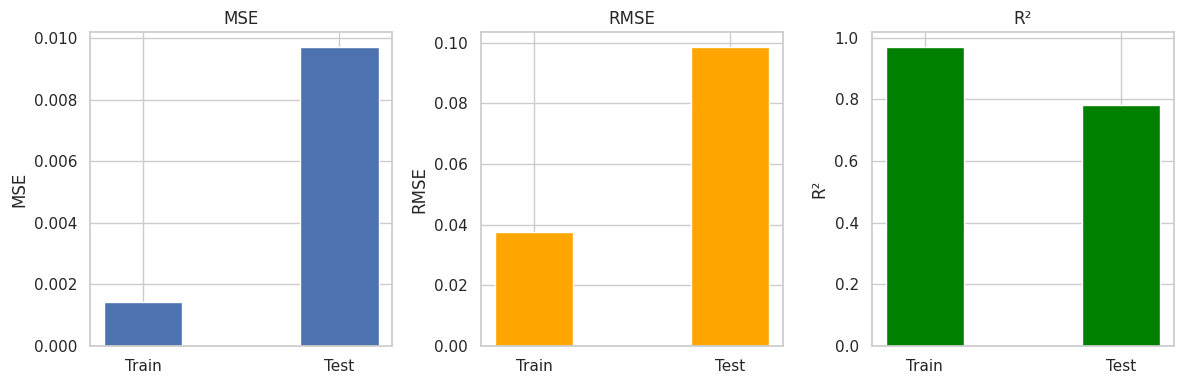

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style
sns.set(style="whitegrid")

# Data for plotting
metrics = ['MSE', 'RMSE', 'R²']
training_scores = [0.0014137342183336333, 0.03759965715712888, 0.9689838861906248]
test_scores = [0.009705949689442826, 0.09851877835947229, 0.781844647208765]

# Plotting MSE
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
bar_width = 0.4
index = np.arange(2)
plt.bar(index, [training_scores[0], test_scores[0]], bar_width, label='MSE')
plt.xticks(index, ['Train', 'Test'])
plt.title('MSE')
plt.ylabel('MSE')

# Plotting RMSE
plt.subplot(1, 3, 2)
plt.bar(index, [training_scores[1], test_scores[1]], bar_width, label='RMSE', color='orange')
plt.xticks(index, ['Train', 'Test'])
plt.title('RMSE')
plt.ylabel('RMSE')

# Plotting R²
plt.subplot(1, 3, 3)
plt.bar(index, [training_scores[2], test_scores[2]], bar_width, label='R²', color='green')
plt.xticks(index, ['Train', 'Test'])
plt.title('R²')
plt.ylabel('R²')

plt.tight_layout()
plt.show()


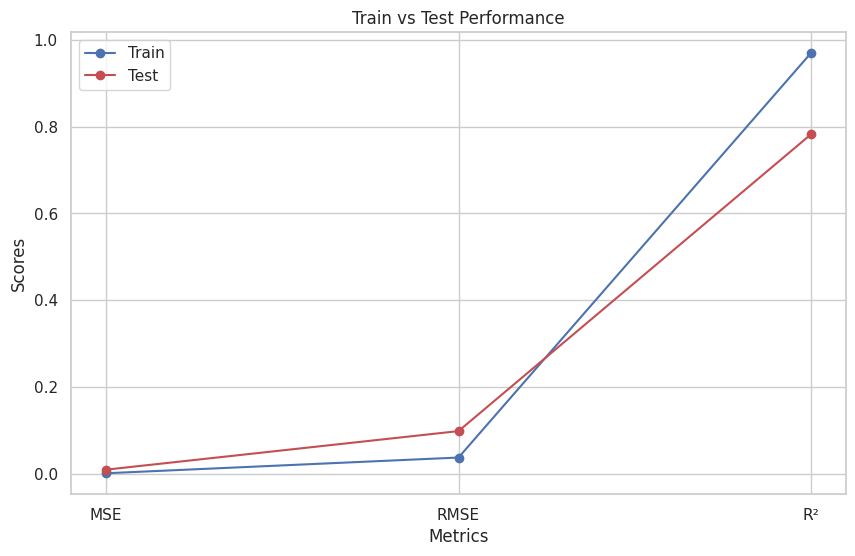

In [ ]:
plt.figure(figsize=(10, 6))

# Data for plotting
metrics = ['MSE', 'RMSE', 'R²']
train_scores = [0.0014137342183336333, 0.03759965715712888, 0.9689838861906248]
test_scores = [0.009705949689442826, 0.09851877835947229, 0.781844647208765]

plt.plot(metrics, train_scores, marker='o', label='Train', color='b')
plt.plot(metrics, test_scores, marker='o', label='Test', color='r')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Train vs Test Performance')
plt.legend()
plt.grid(True)
plt.show()
